In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import time
import glob
from glob import glob
import tensorflow
from tqdm import tqdm
from itertools import chain
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import datetime
import keras



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))
        
print('Started!')

Using TensorFlow backend.


Started!


## NIH Chest X-ray Dataset
Attempting to recreate the code and results of the stanford paper: https://arxiv.org/pdf/1711.05225.pdf
- Their algorithm was called CheXNet
- This paper achieved an F1 score of 0.435 on Pneumonia Classification

This dataset contains 112,120 Frontal View Chest X-ray images

It contains the pathologies of 14 thoracic diseases: Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass, Nodule, Pneumonia, Pneumothorax, Consolidation, Edema, Emphysema, Fibrosis, Pleural Thickening, and Hernia

In [2]:
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
#print(df.head(5))

In [3]:
#os.mkdir('weights')
#os.mkdir('logs')

In [4]:
# HYPERPARAMETERS
IMG_SIZE = (224,224)
SEED = 3
BATCH_SIZE = 16
EPOCHS = 100
IMG_SHAPE = (224,224,3)
BASE_MODEL_TRAINABLE = True
OUTPUT_CLASSES = 1

WEIGHTS_DIR = "weights/"

In [5]:
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

In [6]:
# Figuring out how many patients we have
num_glob = glob('/kaggle/input/data/*/images/*.png')
print(f'There are {len(num_glob)} images in the entire dataset')

There are 112120 images in the entire dataset


In [7]:
# Mapping Images to their respective Paths
img_path = {os.path.basename(x): x for x in num_glob}
labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
#print(labels_df.head())

In [8]:
# One hot encoding all Diseases
for diseases in tqdm(disease_labels): #TQDM is a progress bar setting
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)
#print(labels_df.head())

100%|██████████| 14/14 [00:01<00:00, 13.29it/s]


In [9]:
#labels_df['All_Diseases_Targets'] = labels_df.apply(lambda result: [result[disease_labels].values],1).map(lambda result:result[0])
#labels_df['All_Diseases_Targets'].astype(str)
#print(labels_df)

In [10]:
labels_df['Pneumonia'] = labels_df['Pneumonia'].astype(str)
labels_df[disease_labels].astype(str)

#x = labels_df['Pneumonia']


,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112117,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112118,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Number of training samples for each diseases
num_disease = labels_df[disease_labels].sum().sort_values(ascending=False)
#print(num_disease)

## Preprocessing for Pneumonia (different for the 14 muti class)
Training and Testing Distributions:
- Training = 28,744 Patients, 98,637 Images 
- Validation = 1,672 Patients, 6,351 Images
- Testing = 389 Patients, 420 Images

No patient is overlapped in between training/test sets

The images are downsampled to 224x224
- Normalized based on mean and standard deviation of images in the imagenet training set
 
Augmentation:
- They only do Random horizontal flipping

In [12]:
patients = np.unique(labels_df['Patient_ID'])
print('Number of Patients Overall: ', len(patients))


train_df, test_df = train_test_split(patients, 
                                   test_size = 0.0126,
                                   random_state = 2017,
                                    shuffle= True
                                   #stratify=labels_df[['Pneumonia']]
                                   )


train_df, val_df = train_test_split(train_df, 
                                   test_size = 0.05,
                                   random_state = 2017,
                                    shuffle= True
                                   #stratify=labels_df[['Pneumonia']]
                                   )

Number of Patients Overall:  30805


In [13]:
print('No. of Unique Patients in Train dataset : ',len(train_df))
print('No. of Unique Patients in Validtion dataset : ',len(val_df))
print('No. of Unique Patients in Testing dataset : ',len(test_df))

No. of Unique Patients in Train dataset :  28895
No. of Unique Patients in Validtion dataset :  1521
No. of Unique Patients in Testing dataset :  389


In [14]:
train_df = labels_df[labels_df['Patient_ID'].isin(train_df)]
print('\nTraining Dataframe   : ', train_df.shape[0],' images')


val_df = labels_df[labels_df['Patient_ID'].isin(val_df)]
print('\nValidation Dataframe   : ', val_df.shape[0],' images')

test_df = labels_df[labels_df['Patient_ID'].isin(test_df)]
print('\nTesting Dataframe   : ', test_df.shape[0],' images')


Training Dataframe   :  105096  images

Validation Dataframe   :  5495  images

Testing Dataframe   :  1529  images


In [15]:
print('Count of each Disease in the Train dataset')
for c_label in disease_labels:
    #print(c_label,int(train_df[c_label].sum()))
    pass

Count of each Disease in the Train dataset


In [16]:
IMG_SIZE = (224, 224)
train_data_gen = ImageDataGenerator(rescale=1./255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True
                             )

test_and_val_data_gen = ImageDataGenerator(rescale=1./255)



In [17]:
train_gen = train_data_gen.flow_from_dataframe(dataframe=train_df, 
                                                directory=None,
                                                shuffle= True,
                                                seed = SEED,
                                                x_col = 'Paths',
                                                y_col = 'Pneumonia', 
                                                target_size = IMG_SIZE,
                                                class_mode='binary',
                                                color_mode = 'rgb',
                                                batch_size = 16)

val_gen = test_and_val_data_gen.flow_from_dataframe(dataframe=val_df, 
                                                directory=None,
                                                shuffle= True,
                                                seed = SEED,
                                                x_col = 'Paths',
                                                y_col = 'Pneumonia', 
                                                target_size = IMG_SIZE,
                                                class_mode='binary',
                                                color_mode = 'rgb'
                                                )



test_gen = test_and_val_data_gen.flow_from_dataframe(dataframe=test_df, 
                                                directory=None,
                                                shuffle = True,
                                                seed = SEED,
                                                x_col = 'Paths',
                                                y_col = 'Pneumonia', 
                                                target_size = IMG_SIZE,
                                                class_mode='binary',
                                                color_mode = 'rgb',
                                                batch_size = 16)

Found 105096 validated image filenames belonging to 2 classes.
Found 5495 validated image filenames belonging to 2 classes.
Found 1529 validated image filenames belonging to 2 classes.


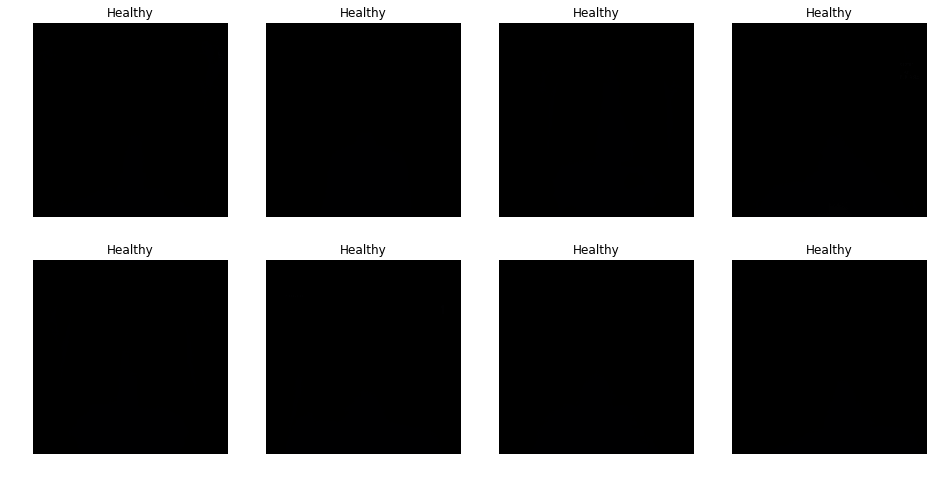

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 255)
    c_ax.set_title('%s' % ('Inflitration' if c_y>0.5 else 'Healthy'))
    c_ax.axis('off')

## DenseNet-121
This is a pretrained network that was trained on ImageNet. It consists of 121 convolutional layers. The Stanford team added Dense connections and batch normalization to speed up training and improve accuracy. The output of the model is a binary label {0,1}. They replace the final layer with a one that has a single output. The use a sigmoid activation function for the last layer. They train the model using mini-batches. They have a decaying learning rate, initialized at 0.001 and decayed by a factor of 10 every time validation loss plateaus after an epoch. They chose the model with the lowest validation loss. 

- F1 Score (95% CI) = 0.435 (0.387, 0.481)
- Loss = Weighted Binary Cross Entropy
- Optimizer = Adam (B1=0.9, B2=0.999)
- Mini-Batches = 16
- Learning Rate = 0.001 (decay)




In [19]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.0 MB 2.9 MB/s 


In [20]:
# DenseNet Dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
#from tf.nn import weighted_cross_entropy_with_logits
from tensorflow_addons.metrics import F1Score

# Weighted Binary Cross Entropy 

In [21]:
from tensorflow import nn

#new = tf.nn.weighted_cross_entropy_with_logits()

In [22]:
# My Version
bce = tf.keras.losses.BinaryCrossentropy()
loss = bce([0., 0., 1., 1.], [1., 1., 1., 0.])
print('Loss: ', loss.numpy())

Loss:  11.522857


In [23]:
weights = model.get_weights()
model.set_weights(weights)

NameError: name 'model' is not defined

In [24]:
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#base_model.summary()
base_model.trainable = BASE_MODEL_TRAINABLE

x = base_model.output

x = GlobalAveragePooling2D()(x)
predictions = Dense(OUTPUT_CLASSES, activation='sigmoid',name='Final')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()

29089792/29084464 [==============================] - 0s 0us/step


In [25]:
checkpoint = ModelCheckpoint(WEIGHTS_DIR + 'CheXNet14.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

In [26]:
reduced_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.05, patience=7, verbose=1, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [27]:
OPTIMIZER = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

LOSS = BinaryCrossentropy() # I don't know if this is un-weighted Binary Cross Entropy

METRICS = ['BinaryAccuracy','AUC']

In [28]:
#LOSS = WeightedBinaryLoss(w_class0, w_class1)

In [29]:
model.compile(loss=LOSS, #WeightedBinaryCrossEntropy(pos_weight=0.5, weight = 2, from_logits=True),
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

In [30]:
history = model.fit( 
    train_gen,
    steps_per_epoch = 5216 // BATCH_SIZE,
    #steps_per_epoch = 1,
    validation_data = val_gen,
    validation_steps=64,
    epochs=EPOCHS,
    callbacks=[reduced_lr, checkpoint]
)


Train for 326 steps, validate for 64 steps
Epoch 1/100
325/326 [============================>.] - ETA: 0s - loss: 0.2755 - BinaryAccuracy: 0.9846 - AUC: 0.5178
Epoch 00001: val_loss improved from inf to 2.56720, saving model to weights/CheXNet14.h5


AttributeError: 'OSError' object has no attribute 'message'

In [31]:
model.save_weights("weights")

## Results

AUC Scores
- Atelectasis	= 0.8094
- Cardiomegaly = 0.9248
- Consolidation = 0.7901
- Edema = 0.8878
- Effusion = 0.8638
- Emphysema = 0.9371
- Fibrosis = 0.8047
- Hernia = 0.9164
- Infiltration = 0.7345
- Mass = 0.8676
- Nodule = 0.7802
- Pleural Thickening = 0.8062
- **Pneumonia = 0.7680 **********
- Pneumothorax = 0.8887


In [32]:
acc = history.history['BinaryAccuracy']
val_acc = history.history['val_BinaryAccuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [33]:
score = model.evaluate(test_gen)
print(f'Model Test Loss: {score[0]}')
print(f'Model Test Accuracy: {score[1]}')

96/96 [==============================] - 32s 331ms/step - loss: 4.6402 - BinaryAccuracy: 0.9817 - AUC: 0.5000
Model Test Loss: 4.640246599912643
Model Test Accuracy: 0.9816873669624329


In [34]:
test_Y = model.predict(test_gen)
orig = test_gen.classes
print(classification_report(orig, test_Y>0.5, target_names = ['Healthy', 'Pneumonia']))

              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99      1501
   Pneumonia       0.00      0.00      0.00        28

    accuracy                           0.98      1529
   macro avg       0.49      0.50      0.50      1529
weighted avg       0.96      0.98      0.97      1529



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


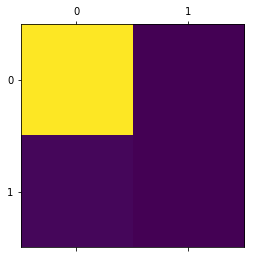

In [35]:
plt.matshow(confusion_matrix(orig, test_Y>0.5))